## Import Dependencies

In [1]:
# COCO related libraries
from samples.coco import coco

# MaskRCNN libraries
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

# Misc
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

Using TensorFlow backend.


## Constants

In [2]:
# Number of classes in dataset. Must be of type integer
NUM_CLASSES = 3

# Relative path to .h5 weights file
WEIGHTS_FILE = None

# Relative path to annotations JSON file
TRAIN_ANNOTATIONS_FILE = "datasets/Downtown_Sliced/train/annotations_split.json"

# Relative path to directory of images that pertain to annotations file
TRAIN_ANNOTATION_IMAGE_DIR = 'datasets/Downtown_Sliced/train/images'

# Relative path to annotations JSON file
VALIDATION_ANNOTATIONS_FILE = "datasets/Downtown_Sliced/validation/annotations_split.json"

# Relative path to directory of images that pertain to annotations file
VALIDATION_ANNOTATION_IMAGE_DIR = 'datasets/Downtown_Sliced/validation/images'

# Number of epochs to train dataset on
NUM_EPOCHS = 80

MODEL_NAME = "model_2"

## Additional setup

In [3]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Select which GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

## Declare training configuration

In [4]:
class TrainConfig(coco.CocoConfig):
    """
    """
    # Give the configuration a recognizable name
    NAME = MODEL_NAME

    # Train on 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + NUM_CLASSES

    # Min and max image dimensions
    IMAGE_MIN_DIM = 1152
    IMAGE_MAX_DIM = 1280

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 180

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Changed to 512 because that's how many the original MaskRCNN paper used
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000 
    POST_NMS_ROIS_TRAINING = 2000 
    
    DETECTION_MAX_INSTANCES = 114
    DETECTION_MIN_CONFIDENCE = 0.1

## Display configuration

In [5]:
TrainConfig().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        114
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  1152
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Create class to load dataset

In [6]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

## Load train and validation datasets

In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data(TRAIN_ANNOTATIONS_FILE, TRAIN_ANNOTATION_IMAGE_DIR)
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data(VALIDATION_ANNOTATIONS_FILE, VALIDATION_ANNOTATION_IMAGE_DIR)
dataset_val.prepare()

## Build MaskRCNN Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode = "training", config = TrainConfig(), model_dir = MODEL_DIR)

W0805 20:55:55.028046 139871543367488 deprecation_wrapper.py:119] From /home/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 20:55:55.066967 139871543367488 deprecation_wrapper.py:119] From /home/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 20:55:55.108044 139871543367488 deprecation_wrapper.py:119] From /home/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 20:55:55.145821 139871543367488 deprecation_wrapper.py:119] From /home/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 20:56:01.127417 139871543367488 deprecation_wrapp

## Load weights into model if weights file is not None
### This is meant to be used if you are refining on a set of preexisting weights

In [9]:
if WEIGHTS_FILE is not None:
    model.load_weights(WEIGHTS_FILE, by_name = True)

## Train model
### The model after each epoch will be saved in the logs folder

In [10]:
start_train = time.time()
model.train(dataset_train, dataset_val, learning_rate = TrainConfig().LEARNING_RATE, epochs = NUM_EPOCHS, layers = 'all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/logs/model_220190805T2055/mask_rcnn_model_2_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

W0805 20:56:06.696414 139871543367488 deprecation_wrapper.py:119] From /home/venv/lib/python3.6/site-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/home/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/80
179/180 [============================>.] - ETA: 1s - loss: 5.9014 - rpn_class_loss: 1.3325 - rpn_bbox_loss: 2.6158 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 1.0787 - mrcnn_mask_loss: 0.6884

/home/venv/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


180/180 [==============================] - 269s 1s/step - loss: 5.8876 - rpn_class_loss: 1.3288 - rpn_bbox_loss: 2.6091 - mrcnn_class_loss: 0.1854 - mrcnn_bbox_loss: 1.0758 - mrcnn_mask_loss: 0.6884 - val_loss: 4.0981 - val_rpn_class_loss: 0.6354 - val_rpn_bbox_loss: 1.8011 - val_mrcnn_class_loss: 0.3238 - val_mrcnn_bbox_loss: 0.6641 - val_mrcnn_mask_loss: 0.6737
Epoch 2/80
180/180 [==============================] - 234s 1s/step - loss: 3.4330 - rpn_class_loss: 0.5944 - rpn_bbox_loss: 1.3371 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.6185 - mrcnn_mask_loss: 0.6448 - val_loss: 3.3771 - val_rpn_class_loss: 0.5592 - val_rpn_bbox_loss: 1.2950 - val_mrcnn_class_loss: 0.2990 - val_mrcnn_bbox_loss: 0.6195 - val_mrcnn_mask_loss: 0.6044
Epoch 3/80
180/180 [==============================] - 221s 1s/step - loss: 2.9889 - rpn_class_loss: 0.5030 - rpn_bbox_loss: 1.0623 - mrcnn_class_loss: 0.3170 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.6045 - val_loss: 3.1165 - val_rpn_class_loss: 0.4647

Epoch 23/80
180/180 [==============================] - 232s 1s/step - loss: 2.0797 - rpn_class_loss: 0.2389 - rpn_bbox_loss: 0.8591 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.3658 - val_loss: 2.6840 - val_rpn_class_loss: 0.3440 - val_rpn_bbox_loss: 1.1922 - val_mrcnn_class_loss: 0.2098 - val_mrcnn_bbox_loss: 0.4733 - val_mrcnn_mask_loss: 0.4648
Epoch 24/80
180/180 [==============================] - 241s 1s/step - loss: 2.1009 - rpn_class_loss: 0.2336 - rpn_bbox_loss: 0.8728 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.3654 - val_loss: 2.4940 - val_rpn_class_loss: 0.3490 - val_rpn_bbox_loss: 0.9723 - val_mrcnn_class_loss: 0.2863 - val_mrcnn_bbox_loss: 0.4303 - val_mrcnn_mask_loss: 0.4561
Epoch 25/80
180/180 [==============================] - 241s 1s/step - loss: 2.0984 - rpn_class_loss: 0.2460 - rpn_bbox_loss: 0.8662 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.3610 - val_loss: 2.5445 - val_rpn_clas

Epoch 45/80
180/180 [==============================] - 241s 1s/step - loss: 1.7672 - rpn_class_loss: 0.1695 - rpn_bbox_loss: 0.6976 - mrcnn_class_loss: 0.2776 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.3343 - val_loss: 2.0572 - val_rpn_class_loss: 0.1987 - val_rpn_bbox_loss: 0.7968 - val_mrcnn_class_loss: 0.2526 - val_mrcnn_bbox_loss: 0.3657 - val_mrcnn_mask_loss: 0.4434
Epoch 46/80
180/180 [==============================] - 238s 1s/step - loss: 1.8969 - rpn_class_loss: 0.2024 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.3335 - val_loss: 2.3995 - val_rpn_class_loss: 0.2850 - val_rpn_bbox_loss: 1.0118 - val_mrcnn_class_loss: 0.2202 - val_mrcnn_bbox_loss: 0.4175 - val_mrcnn_mask_loss: 0.4650
Epoch 47/80
180/180 [==============================] - 243s 1s/step - loss: 1.8108 - rpn_class_loss: 0.1841 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.3409 - val_loss: 2.6733 - val_rpn_clas

Epoch 67/80
180/180 [==============================] - 235s 1s/step - loss: 1.8472 - rpn_class_loss: 0.1885 - rpn_bbox_loss: 0.8501 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.2625 - mrcnn_mask_loss: 0.3167 - val_loss: 2.5372 - val_rpn_class_loss: 0.3245 - val_rpn_bbox_loss: 1.1161 - val_mrcnn_class_loss: 0.2582 - val_mrcnn_bbox_loss: 0.4051 - val_mrcnn_mask_loss: 0.4332
Epoch 68/80
180/180 [==============================] - 234s 1s/step - loss: 1.6300 - rpn_class_loss: 0.1551 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.3023 - val_loss: 2.3938 - val_rpn_class_loss: 0.2959 - val_rpn_bbox_loss: 0.9789 - val_mrcnn_class_loss: 0.2810 - val_mrcnn_bbox_loss: 0.3890 - val_mrcnn_mask_loss: 0.4491
Epoch 69/80
180/180 [==============================] - 241s 1s/step - loss: 1.7700 - rpn_class_loss: 0.1706 - rpn_bbox_loss: 0.7860 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.2563 - mrcnn_mask_loss: 0.3098 - val_loss: 2.3985 - val_rpn_clas

## Include evaluation scripts in training script so that the kernel does not have to be reloaded. Eases the process of rapidly training and evaluating models

## Import dependencies

In [18]:
# COCO related libraries
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from samples.coco import coco
from samples.coco.coco import evaluate_coco
from pycocotools.coco import COCO

# MaskRCNN libraries
import mrcnn.model as modellib
import mrcnn.utils as utils
import mrcnn.visualize as visualize

# Misc
import os
import skimage.io
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tnrange, tqdm_notebook

## Declare evaluation configuration

In [12]:
class EvalConfig(coco.CocoConfig):
    """ Configuration for evaluation """
    
    # Give the configuration a recognizable name
    NAME = MODEL_NAME
    
    # How many GPUs
    GPU_COUNT = 1
    
    # How many images per gpu
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + NUM_CLASSES  # background + other classes
    
    IMAGE_MIN_DIM = 1152
    IMAGE_MAX_DIM = 1280
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Changed to 512 because that's how many the original MaskRCNN paper used
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000 
    POST_NMS_ROIS_TRAINING = 2000 
    
    DETECTION_MAX_INSTANCES = 114
    DETECTION_MIN_CONFIDENCE = 0.1

## Display configuration

In [13]:
EvalConfig().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        114
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  1152
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Build class to load ground truth data

In [14]:
class CocoDataset(utils.Dataset):
    def load_coco_gt(self, annotations_file, dataset_dir):
        """Load a COCO styled ground truth dataset
        """
        
        # Create COCO object
        coco = COCO(annotations_file)

        # Load all classes
        class_ids = sorted(coco.getCatIds())

        # Load all images
        image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id = i,
                path = os.path.join(dataset_dir, coco.imgs[i]['file_name']),
                width = coco.imgs[i]["width"],
                height = coco.imgs[i]["height"],
                annotations = coco.loadAnns(coco.getAnnIds(
                    imgIds = [i], catIds = class_ids, iscrowd=None)))
        
        return coco
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

## Build MaskRCNN Model

In [15]:
# Create the model in inference mode
model = modellib.MaskRCNN(mode = "inference", config = EvalConfig(), model_dir = MODEL_DIR)

W0806 02:20:35.781523 139871543367488 deprecation_wrapper.py:119] From /home/venv/src/mask-rcnn/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0806 02:20:35.898080 139871543367488 deprecation.py:323] From /home/venv/src/mask-rcnn/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


## Load weights from last trained model

In [16]:
# Load weights by name
model.load_weights(model.find_last(), by_name = True)

Re-starting from epoch 80


## Load dataset

In [19]:
# Relative path to ground truth annotations JSON file
GT_ANNOTATIONS_FILE = "datasets/Downtown_Sliced/test/annotations_split.json"

# Relative path to images associated with ground truth JSON file
GT_DATASET_DIR = "datasets/Downtown_Sliced/test/images"

dataset_val = CocoDataset()
coco = dataset_val.load_coco_gt(annotations_file = GT_ANNOTATIONS_FILE, dataset_dir = GT_DATASET_DIR)
dataset_val.prepare()

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!


## Evaluate model with COCO test
### If your results come back as a bunch of zeros, check to make sure that the "width" and "height" tag in your COCO dataset are correct

In [ ]:
evaluate_coco(model, dataset_val, coco, "segm")

## Calculating mAP as per example in train_shapes.ipynb

In [20]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, len(dataset_val.image_ids))

# Instanciate arrays to create our metrics
APs = []
precisions_arr = []
recalls_arr = []
overlaps_arr = []
class_ids_arr = []
scores_arr = []

for id in tnrange(len(image_ids), desc = "Processing images in dataset..."):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, EvalConfig(),
                               image_ids[id], use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, EvalConfig()), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    # Append AP to AP array
    APs.append(AP)
    
    # Append precisions
    for precision in precisions:
        precisions_arr.append(precision)
    
    # Append recalls
    for recall in recalls:
        recalls_arr.append(recall)
    
    # Append overlaps
    for overlap in overlaps:
        overlaps_arr.append(overlap)
    
    # Append class_ids
    for class_id in r["class_ids"]:
        class_ids_arr.append(class_id)
    
    # Append scores 
    for score in r["scores"]:
        scores_arr.append(score)
    
print("mAP: ", np.mean(APs))


mAP:  0.3197467292721128


## Plot precision recall curve

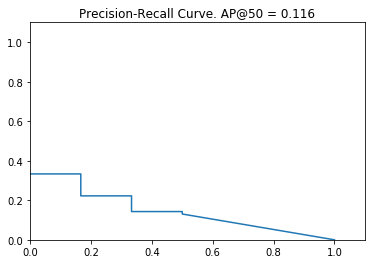

In [21]:
visualize.plot_precision_recall(AP, precisions, recalls)